##### <h1><center>Property Price Analysis - Brisbane Southern Suburbs 2019</center></h1> #####


**Background story:**<br>
    My friend JV has been promoted to a manager role recently, while his income grows and the Bank interest rate is at historical low, he is looking for an investment property. As his best friend, I'm trying to help him with my data science skills.<br>
                                                                <br>
    We are targeting at Southern Suburbs in Brisbane, QLD, Australia, not only because the rapid population growth in this area, the large investments in infrastructures and potential bid for 2032 Olympic Games, but also JV wants to have it close to where he lives so he could manage the property and tenants himself.<br>

**The problem we want to solve:**<br>
   Of all the Southern suburbs in Brisbane, we would like to find out which ones are most undervalued and worth investing.

**Brisbane- A beautiful coastal city with 2.5 Million people**
<img src="https://www.planetware.com/photos-large/AUS/australia-brisbane-city-2.jpg">

### The Plan:

**Data were sourced from below:**<br>

Brisbane Suburb List:https://www.brisbane.qld.gov.au/about-council/council-information-and-rates/brisbane-suburbs

Brisbane Region Classification:https://en.wikipedia.org/wiki/List_of_Brisbane_suburbs

Geospatial Data: http://www.corra.com.au/australian-postcode-location-data/ 

Brisbane House Information by Suburbs:https://homesales.com.au/location/brisbane-qld/ 

Venues Information: https://api.foursquare.com/v2/venues/

We will collect Brisbane Suburb list, regions classifications, geospatial data, house informations such as Median House Price 2019, Population and income, venues information from fourSquare Api.

**Methodology**<br>

Using Unsupervised Machine Learning Algorithms:K-means clustering to cluster the suburbs.(Using Elbow Graph to find the best K)<br>

Then using Supervised Machine Learning Algorithms:Multiple linear regression to set up the model.<br>

Using Regions other than Southern to train the model and then predict Southern Region suburbs house prices, comparing the predicted value with the market value to determine whether the suburb is undervalued or not.<br>



**Install the required packages**

In [1]:
!pip install lxml
!pip install folium==0.5.0
!pip install geopandas
!pip install descartes

     |████████████████████████████████| 81kB 1.3MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
     |████████████████████████████████| 901kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 11.2MB 35.2MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 47.7MB/s eta 0:00:01
     |████████████████████████████████| 17.9MB 39.7MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [2]:
import requests

from bs4 import BeautifulSoup

import csv

import pandas as pd

import urllib3

from geopy.geocoders import Nominatim

#import folium 

import numpy as np

from sklearn import preprocessing

#import geopandas as gpd

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

urllib3.disable_warnings()

import matplotlib.pyplot as plt

from sklearn import linear_model

import folium

import matplotlib

from matplotlib.ticker import FuncFormatter



**Data Cleaning: removed suburbs with no median house price or no population or income data in May 2019.**

**Some web scrapting codes that I have used:**

urlsuburb='https://raw.githubusercontent.com/Frankherewego/Data-Science-Capstone/master/Suburb.csv'

s=pd.read_csv(urlsuburb)
sblist = list(s['Suburbs'])
headers = {"User-Agent" : "User-Agent:Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0;"}
base_url ='https://homesales.com.au/location/'
for i in sblist:
    url='{}{}'.format(base_url, i)
    #print (url)
    source=requests.get(url,allow_redirects=False,headers=headers,verify=False).text
    soup=BeautifulSoup(source,'lxml')
    try:
        for h1 in soup.find('h1'):
            print (h1)
    except:
        print("no record")
    
        for span in soup.find_all('span',{'class' : 'highlight'}):
        print (span)
**There are some security settings such as verification and call limits in this website, the ways to get around the these are not inclueded in this notebook nor are they relevant to the analysis.**

In [3]:
URL='https://raw.githubusercontent.com/Frankherewego/Data-Science-Capstone/master/Brisbane.csv'
rawdata=pd.read_csv(URL)
rawdata.head()

,Brisbane suburbs,Category,lat,lon,Population,Avg Income,Median House Price
0,Acacia Ridge,Southern,-27.589633,153.027870,6944,619,403843
1,Albion,Northern,-27.428026,153.045205,1986,984,816117
2,Alderley,Northern,-27.424422,153.000517,5680,1040,817877
3,Algester,Southern,-27.611303,153.033518,8262,782,531232
4,Annerley,Southern,-27.511609,153.031832,10664,884,743990


**Data review 1, check data shape and data type**

In [5]:

rawdata.columns = rawdata.columns.str.replace('\s*<.*>\s*$', '')
rawdata.rename(columns={'Brisbane suburbs': 'Suburbs'}, inplace=True)

In [6]:
print(rawdata.shape)

(178, 7)


**Data review 2, check if there is any suburbs has outliners in terms of population**

In [7]:
sort=rawdata.sort_values('Population')
print(sort.head(n=5))
# here we need to exclude the first 3 suburbs as their data size are less than 50 which is not statistically valuable for forecasting.

                Suburbs  Category        lat         lon  Population  \
93               Lytton   Eastern -27.424300  153.155450           6   
53   Enoggera Reservoir   Western -27.429865  152.864844          22   
83            Karawatha  Southern -27.617514  153.093560          33   
167           Willawong  Southern -27.593448  152.998315         193   
118        Nudgee Beach  Northern -27.347485  153.105548         260   

     Avg Income  Median House Price  
93          563              614342  
53         1003              849918  
83          316              746292  
167         655              994213  
118         832              720071  


In [9]:
df=rawdata[rawdata['Population']>50]

print(df.shape)


(175, 7)


**Now the data has been cleaned and ready to use**

**Use geopy library to get the latitude and longitude values of Brisbane City**

In [10]:
address = 'Brisbane,QLD'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brisbane City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brisbane City are -27.4689682, 153.0234991.


**Create a map of Brisbane with suburbs superimposed on top.**

In [11]:
# create map of Toronto using latitude and longitude values
map_Brisbane = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, suburbs,cat in zip(df['lat'], df['lon'], df['Suburbs'],df['Category']):
    label = '{},{}'.format(suburbs,cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Brisbane)  
    
map_Brisbane


**Define Foursquare Credentials and Version.**

In [14]:
#CLIENT_ID = 'XHEOJB4QRYOQCFKLWIDWVXXR022RPEPUQWPUF1DPLUXJJPTT' # your Foursquare ID
#CLIENT_SECRET = 'P4RTL41AECFZWQ1GY1CBIJWBMGAPGD1DFV12KDX0HKHVVCY5' # your Foursquare Secret

CLIENT_ID = 'AENJ1PG3WLYL5KHMZRMT2F0BREVTGQFY1GEAY2JRYDHU5ISC' # your Foursquare ID
CLIENT_SECRET = 'SIIHU2HF52HWINXZYMMYFOLCX0ICYFHGXVCKXAZM4NJ3ASGJ' # your Foursquare Secret
VERSION = '20190805' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AENJ1PG3WLYL5KHMZRMT2F0BREVTGQFY1GEAY2JRYDHU5ISC
CLIENT_SECRET:SIIHU2HF52HWINXZYMMYFOLCX0ICYFHGXVCKXAZM4NJ3ASGJ


**Create a function for venues within suburbs, set up radius as 500 as default and found the data is too small, then changed to 1000**

In [15]:
radius= 1000
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius= 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburbs', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Write the code to run the above function on each suburb and create a new dataframe called Bri_venues**

In [16]:


Bri_venues = getNearbyVenues(names=df['Suburbs'],
                                   latitudes=df['lat'],
                                   longitudes=df['lon']
                                  )




Acacia Ridge
Albion
Alderley
Algester
Annerley
Anstead
Archerfield
Ascot
Ashgrove
Aspley
Auchenflower
Bald Hills
Balmoral
Banyo
Bardon
Bellbowrie
Belmont
Boondall
Bowen Hills
Bracken Ridge
Bridgeman Downs
Brighton
Brisbane
Brookfield
Bulimba
Burbank
Calamvale
Camp Hill
Cannon Hill
Carina
Carina Heights
Carindale
Carseldine
Chandler
Chapel Hill
Chelmer
Chermside
Chermside West
Chuwar
Clayfield
Coopers Plains
Coorparoo
Corinda
Darra
Deagon
Doolandella
Drewvale
Durack
Dutton Park
East Brisbane
Eight Mile Plains
Ellen Grove
Enoggera
Everton Park
Fairfield
Ferny Grove
Fig Tree Pocket
Fitzgibbon
Forest Lake
Fortitude Valley
Gaythorne
Geebung
Gordon Park
Graceville
Grange
Greenslopes
Gumdale
Hamilton
Hawthorne
Heathwood
Hemmant
Hendra
Herston
Highgate Hill
Holland Park
Holland Park West
Inala
Indooroopilly
Jamboree Heights
Jindalee
Kangaroo Point
Karana Downs
Kedron
Kelvin Grove
Kenmore
Kenmore Hills
Keperra
Kholo
Kuraby
Lota
Lutwyche
Macgregor
Mackenzie
Manly
Manly West
Mansfield
McDowall
Mi

In [17]:
print(Bri_venues.shape)
Bri_venues.head()

(3453, 7)


,Suburbs,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acacia Ridge,-27.589633,153.02787,IGA Acacia Ridge,-27.589866,153.027448,Grocery Store
1,Acacia Ridge,-27.589633,153.02787,Subway,-27.585320,153.026710,Sandwich Place
2,Acacia Ridge,-27.589633,153.02787,KFC,-27.587570,153.027600,Fast Food Restaurant
3,Acacia Ridge,-27.589633,153.02787,McDonald's,-27.589040,153.027000,Fast Food Restaurant
4,Acacia Ridge,-27.589633,153.02787,East Coast Group,-27.595745,153.029294,Construction & Landscaping


In [18]:
Bri_venues.groupby('Suburbs').count()

,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Suburbs,,,,,,
Acacia Ridge,5,5,5,5,5,5
Albion,28,28,28,28,28,28
Alderley,14,14,14,14,14,14
Algester,8,8,8,8,8,8
Annerley,32,32,32,32,32,32
Anstead,1,1,1,1,1,1
Archerfield,4,4,4,4,4,4
Ascot,34,34,34,34,34,34
Ashgrove,20,20,20,20,20,20


**Let's find out how many unique categories can be curated from all the returned venues**

In [19]:
print('There are {} uniques categories.'.format(len(Bri_venues['Venue Category'].unique())))

There are 254 uniques categories.


**Analyze Each Neighborhood.**

In [20]:
# one hot encoding
 
bri_onehot = pd.get_dummies(Bri_venues[['Venue Category']], prefix="", prefix_sep="")

# add Suburbs column back to dataframe
bri_onehot['Suburbs'] = Bri_venues['Suburbs'] 

# move Suburbs column to the first column---Please note that the lab codes dont work here, so I used generic reorder codes.
#fixed_columns = [bri_onehot.columns[-1]] + list(bri_onehot.columns[:-1])
#bri_onehot = bri_onehot[fixed_columns]
cols = bri_onehot.columns.tolist()
n = int(cols.index('Suburbs'))
cols = [cols[n]] + cols[:n] + cols[n+1:]
bri_onehot = bri_onehot[cols]

bri_onehot.head()

,Suburbs,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Acacia Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acacia Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acacia Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acacia Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acacia Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
bri_onehot.shape

(3453, 255)

**Next, let's group rows by suburbs and by taking the mean of the frequency of occurrence of each category**

In [22]:
bri_grouped = bri_onehot.groupby('Suburbs').mean().reset_index()
bri_grouped.head()

,Suburbs,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Acacia Ridge,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Albion,0.0,0.0,0.035714,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alderley,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,...,0.0000,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Algester,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Annerley,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0625,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
bri_grouped.shape

(170, 255)

In [24]:
num_top_venues = 5

for hood in bri_grouped['Suburbs']:
    print("----"+hood+"----")
    temp = bri_grouped[bri_grouped['Suburbs'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acacia Ridge----
                        venue  freq
0        Fast Food Restaurant   0.4
1               Grocery Store   0.2
2              Sandwich Place   0.2
3  Construction & Landscaping   0.2
4             Nature Preserve   0.0


----Albion----
                  venue  freq
0                  Café  0.14
1      Sushi Restaurant  0.11
2         Train Station  0.07
3  Fast Food Restaurant  0.07
4        Scenic Lookout  0.04


----Alderley----
                   venue  freq
0            Supermarket  0.07
1           Liquor Store  0.07
2            Pizza Place  0.07
3      Electronics Store  0.07
4  Performing Arts Venue  0.07


----Algester----
                  venue  freq
0         Grocery Store  0.38
1   Japanese Restaurant  0.12
2     Convenience Store  0.12
3                  Park  0.12
4  Gym / Fitness Center  0.12


----Annerley----
          venue  freq
0          Café  0.16
1   Supermarket  0.06
2   Coffee Shop  0.06
3      Pharmacy  0.06
4  Liquor Store  0.06


----Anste

**Let's put that into a pandas dataframe**

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburbs']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Suburbs_venues_sorted = pd.DataFrame(columns=columns)
Suburbs_venues_sorted['Suburbs'] = bri_grouped['Suburbs']

for ind in np.arange(bri_grouped.shape[0]):
    Suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bri_grouped.iloc[ind, :], num_top_venues)

Suburbs_venues_sorted.head()

,Suburbs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Acacia Ridge,Fast Food Restaurant,Grocery Store,Sandwich Place,Construction & Landscaping,Fish Market
1,Albion,Café,Sushi Restaurant,Train Station,Fast Food Restaurant,Sandwich Place
2,Alderley,Bowling Green,Grocery Store,Performing Arts Venue,Pool,Electronics Store
3,Algester,Grocery Store,Gym / Fitness Center,Japanese Restaurant,Convenience Store,Park
4,Annerley,Café,Park,Pharmacy,Liquor Store,Vietnamese Restaurant


**Using Elbow method to find the best K**

In [29]:
findK=bri_grouped.loc[:, bri_grouped.columns != 'Suburbs']
findK.head()

,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.035714,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,...,0.0000,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0625,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(findK)
    Sum_of_squared_distances.append(km.inertia_)

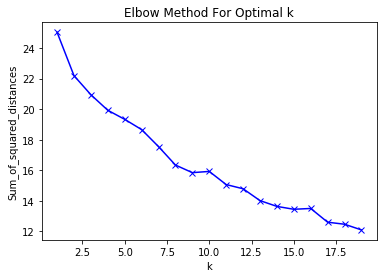

In [27]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**The algorithm is not working too well as sum of error is still trending downwards even when K=20, let's add in pop,income and house price only**

In [32]:
bri_grouped2=pd.merge(bri_grouped, df, on='Suburbs', how='inner')
bri_grouped2.head()

,Suburbs,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Category,lat,lon,Population,Avg Income,Median House Price
0,Acacia Ridge,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,Southern,-27.589633,153.027870,6944,619,403843
1,Albion,0.0,0.0,0.035714,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,Northern,-27.428026,153.045205,1986,984,816117
2,Alderley,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,...,0.0,0.0,0.0,0.0,Northern,-27.424422,153.000517,5680,1040,817877
3,Algester,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,Southern,-27.611303,153.033518,8262,782,531232
4,Annerley,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,Southern,-27.511609,153.031832,10664,884,743990


**Drop lat, lon and Category, then normalise using Min Max Scale**

In [33]:
findK2 = bri_grouped2.drop(['lat','lon','Suburbs','Category'], axis=1)
findK2.head()

,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,...,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Population,Avg Income,Median House Price
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6944,619,403843
1,0.0,0.0,0.035714,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1986,984,816117
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5680,1040,817877
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8262,782,531232
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10664,884,743990


In [34]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(findK2)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303648,0.139976,0.093183
1,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080646,0.572954,0.424791
2,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246795,0.639383,0.426207
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.362929,0.333333,0.195647
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470967,0.454330,0.366776


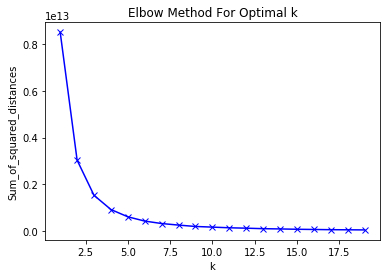

In [31]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(findK2)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Now the Elbow Graph shows much clear results, K=5 seems to be the reasonable choice.**

**Cluster Neighborhoods**

In [35]:
# set number of clusters
kclusters = 5

bri_grouped_clustering = findK2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bri_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 0, 3, 3, 0, 1, 4, 3], dtype=int32)

**Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.**

In [36]:
# add clustering labels
Suburbs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bri_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bri_merged = bri_merged.join(Suburbs_venues_sorted.set_index('Suburbs'), on='Suburbs')

bri_merged.head() # check the last columns!

,Suburbs,Category,lat,lon,Population,Avg Income,Median House Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Acacia Ridge,Southern,-27.589633,153.027870,6944,619,403843,0.0,Fast Food Restaurant,Grocery Store,Sandwich Place,Construction & Landscaping,Fish Market
1,Albion,Northern,-27.428026,153.045205,1986,984,816117,2.0,Café,Sushi Restaurant,Train Station,Fast Food Restaurant,Sandwich Place
2,Alderley,Northern,-27.424422,153.000517,5680,1040,817877,2.0,Bowling Green,Grocery Store,Performing Arts Venue,Pool,Electronics Store
3,Algester,Southern,-27.611303,153.033518,8262,782,531232,0.0,Grocery Store,Gym / Fitness Center,Japanese Restaurant,Convenience Store,Park
4,Annerley,Southern,-27.511609,153.031832,10664,884,743990,3.0,Café,Park,Pharmacy,Liquor Store,Vietnamese Restaurant


**Filter out the NaN Cluster Rows**

In [37]:
bri_merged= bri_merged.dropna(subset=['Cluster Labels'])

bri_merged['Cluster Labels'] = bri_merged['Cluster Labels'].astype(int)
bri_merged.head()
bri_merged.dtypes

Suburbs                   object
Category                  object
lat                      float64
lon                      float64
Population                 int64
Avg Income                 int64
Median House Price         int64
Cluster Labels             int64
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
dtype: object

**Finally, let's visualize the resulting clusters**

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bri_merged['lat'], bri_merged['lon'], bri_merged['Suburbs'], bri_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [39]:
clu1=bri_merged.loc[bri_merged['Cluster Labels'] == 0, bri_merged.columns[[0]+ [1]+ list(range(4, bri_merged.shape[1]))]]

In [40]:
clu1

,Suburbs,Category,Population,Avg Income,Median House Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Acacia Ridge,Southern,6944,619,403843,0,Fast Food Restaurant,Grocery Store,Sandwich Place,Construction & Landscaping,Fish Market
3,Algester,Southern,8262,782,531232,0,Grocery Store,Gym / Fitness Center,Japanese Restaurant,Convenience Store,Park
6,Archerfield,Southern,510,685,389395,0,Market,Airport,Grocery Store,Café,Flea Market
11,Bald Hills,Northern,5964,773,442621,0,Indian Restaurant,Nature Preserve,Park,Fabric Shop,French Restaurant
13,Banyo,Northern,5607,814,541589,0,Café,Train Station,Golf Course,Fabric Shop,French Restaurant
15,Bellbowrie,Western,5413,930,518465,0,Office,Bus Station,Café,Gym,Fast Food Restaurant
17,Boondall,Northern,8746,763,520992,0,Bus Station,Indian Restaurant,Bakery,Platform,Pet Store
19,Bracken Ridge,Northern,16799,804,522434,0,Noodle House,Supermarket,Convenience Store,Fast Food Restaurant,Shopping Mall
21,Brighton,Northern,9011,802,521695,0,Liquor Store,Home Service,Soccer Field,Pharmacy,Bus Station
38,Chuwar,Western,1876,889,470184,0,Indie Movie Theater,Fabric Shop,Fried Chicken Joint,French Restaurant,Football Stadium


**Seems to be suburbs with low income and cheap house prices**

In [41]:
clu2=bri_merged.loc[bri_merged['Cluster Labels'] == 1, bri_merged.columns[[0]+ [1]+ list(range(4, bri_merged.shape[1]))]]
clu2.shape

(7, 11)

In [42]:
clu2

,Suburbs,Category,Population,Avg Income,Median House Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,Ascot,Northern,5730,1081,1531249,1,Café,Japanese Restaurant,Grocery Store,Burger Joint,Train Station
24,Bulimba,Eastern,5940,1200,1217211,1,Coffee Shop,Sushi Restaurant,Pizza Place,Park,Italian Restaurant
25,Burbank,Southern,1137,966,1333318,1,Trail,Yoga Studio,Frozen Yogurt Shop,French Restaurant,Football Stadium
33,Chandler,Eastern,1421,956,1374398,1,Fast Food Restaurant,Sandwich Place,Grocery Store,Sporting Goods Shop,Toy / Game Store
68,Hamilton,Northern,4720,1131,1220765,1,Café,Pizza Place,Japanese Restaurant,Grocery Store,Burger Joint
69,Hawthorne,Eastern,4776,1133,1275225,1,Italian Restaurant,Deli / Bodega,Gift Shop,Theater,French Restaurant
112,New Farm,Inner,11330,1087,1424082,1,Café,Italian Restaurant,Boat or Ferry,Hotel,Bowling Green


**Seems to be expensive and upclass suburbs with Italian/Japanese/French restaurants**

In [43]:
clu3=bri_merged.loc[bri_merged['Cluster Labels'] == 2, bri_merged.columns[[0]+[1]+list(range(4, bri_merged.shape[1]))]]
clu3.shape

(45, 11)

In [44]:
clu3

,Suburbs,Category,Population,Avg Income,Median House Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Albion,Northern,1986,984,816117,2,Café,Sushi Restaurant,Train Station,Fast Food Restaurant,Sandwich Place
2,Alderley,Northern,5680,1040,817877,2,Bowling Green,Grocery Store,Performing Arts Venue,Pool,Electronics Store
18,Bowen Hills,Inner,1744,997,856699,2,Café,Coffee Shop,Burger Joint,Gym,Shopping Mall
20,Bridgeman Downs,Northern,7445,1004,782996,2,Bus Station,Park,Yoga Studio,Fabric Shop,French Restaurant
27,Camp Hill,Eastern,10533,1028,871629,2,Café,Indian Restaurant,Liquor Store,Deli / Bodega,Coffee Shop
31,Carindale,Eastern,15577,924,889353,2,Café,Coffee Shop,Department Store,Fast Food Restaurant,Electronics Store
34,Chapel Hill,Western,10167,1037,778839,2,Liquor Store,Supermarket,Portuguese Restaurant,Noodle House,Café
41,Coorparoo,Eastern,14944,996,873902,2,Café,Coffee Shop,Supermarket,Pizza Place,Mexican Restaurant
42,Corinda,Western,4695,918,793294,2,Café,Supermarket,Bakery,Pizza Place,Coffee Shop
49,East Brisbane,Inner,5598,965,876015,2,Pub,Bowling Green,Café,Pizza Place,Sushi Restaurant


**Seems to be typical middle class suburbs with Cafe, Gym and Parks**

In [45]:
clu4=bri_merged.loc[bri_merged['Cluster Labels'] == 3, bri_merged.columns[[0]+[1] + list(range(4, bri_merged.shape[1]))]]
clu4.shape

(56, 11)

In [46]:
clu4

,Suburbs,Category,Population,Avg Income,Median House Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Annerley,Southern,10664,884,743990,3,Café,Park,Pharmacy,Liquor Store,Vietnamese Restaurant
5,Anstead,Western,1529,998,744588,3,Garden Center,Yoga Studio,Fruit & Vegetable Store,Fried Chicken Joint,French Restaurant
9,Aspley,Northern,12594,851,616588,3,Supermarket,Convenience Store,Steakhouse,Fast Food Restaurant,Gym / Fitness Center
16,Belmont,Eastern,4594,936,703804,3,Gun Range,Athletics & Sports,Yoga Studio,Flower Shop,Farmers Market
22,Brisbane,Inner,7888,1134,715328,3,Café,Hotel,Coffee Shop,Bar,Burger Joint
26,Calamvale,Southern,15291,815,682224,3,Indian Restaurant,Pizza Place,Café,Chinese Restaurant,Liquor Store
28,Cannon Hill,Eastern,4507,908,716299,3,Café,Fast Food Restaurant,Supermarket,Department Store,Pizza Place
29,Carina,Eastern,10301,889,662967,3,Bakery,Basketball Court,BBQ Joint,Thai Restaurant,Gym / Fitness Center
30,Carina Heights,Eastern,6111,857,679995,3,Thai Restaurant,Bakery,Liquor Store,Grocery Store,Fast Food Restaurant
32,Carseldine,Northern,8745,865,661224,3,Café,Bakery,Supermarket,Fish & Chips Shop,Coffee Shop


**Seems to be suburbs with middle-low income and low house prices, with Bus Statins and Supermarkets, Liquor shops, etc**

In [47]:
clu5=bri_merged.loc[bri_merged['Cluster Labels'] == 4, bri_merged.columns[[0]+[1] + list(range(4, bri_merged.shape[1]))]]
clu5.shape

(23, 11)

In [48]:
clu5

,Suburbs,Category,Population,Avg Income,Median House Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Ashgrove,Western,12916,1033,966804,4,Café,Indian Restaurant,Cocktail Bar,Sports Club,Fruit & Vegetable Store
10,Auchenflower,Western,5351,1053,1062402,4,Café,Deli / Bodega,Pizza Place,Liquor Store,Coffee Shop
12,Balmoral,Eastern,3827,1110,996219,4,Coffee Shop,Bookstore,Sushi Restaurant,Pizza Place,Café
14,Bardon,Western,9256,1093,952487,4,Coffee Shop,Hungarian Restaurant,Bowling Green,Gym,Bus Station
23,Brookfield,Western,3702,1059,1106664,4,Mobility Store,Yoga Studio,Fruit & Vegetable Store,Fried Chicken Joint,French Restaurant
35,Chelmer,Western,2593,1091,1142473,4,Café,Coffee Shop,Train Station,Convenience Store,Deli / Bodega
39,Clayfield,Northern,10006,1029,1151292,4,Pizza Place,Grocery Store,Café,Sushi Restaurant,Motel
48,Dutton Park,Southern,1471,758,961298,4,Coffee Shop,Café,BBQ Joint,Pool,Bar
67,Gumdale,Eastern,949,978,1051242,4,Indian Restaurant,Bakery,Breakfast Spot,Pizza Place,Shopping Mall
72,Hendra,Northern,4416,1045,981955,4,Racetrack,Shopping Mall,Supermarket,Candy Store,Chocolate Shop


**Clu5 seems to be suburbs with mid-high income and expensive houses, with Cafe as the most common venue**

**We have done unsupervised training to have the suburbs clustered to 5, now we can start to do supervised training to forecast the house price, and compare it with the current price, and to identify the investment opportunities if a suburb is under valued.**

**We will use Category:Inner, Northern, Eastern and Western for training and Southern for predicting and comparing.**

In [49]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

In [50]:
clu1.dtypes

Suburbs                  object
Category                 object
Population                int64
Avg Income                int64
Median House Price        int64
Cluster Labels            int64
1st Most Common Venue    object
2nd Most Common Venue    object
3rd Most Common Venue    object
4th Most Common Venue    object
5th Most Common Venue    object
dtype: object

In [51]:
clu1T=clu1[~clu1['Category'].str.contains('Southern')]
clu1P=clu1[clu1['Category'].str.contains('Southern')]
train1=clu1T[['Population','Avg Income','Median House Price']]
# ['Population','Avg Income','Median House Price']]
print(train1.head())

pred1=clu1P[['Suburbs','Category','Population','Avg Income','Median House Price']]
pred1=pred1.rename(columns={'Category':'Region'})
print(pred1.head())

    Population  Avg Income  Median House Price
11        5964         773              442621
13        5607         814              541589
15        5413         930              518465
17        8746         763              520992
19       16799         804              522434
           Suburbs    Region  Population  Avg Income  Median House Price
0     Acacia Ridge  Southern        6944         619              403843
3         Algester  Southern        8262         782              531232
6      Archerfield  Southern         510         685              389395
40  Coopers Plains  Southern        4207         703              558606
43           Darra  Southern        3838         653              459754


In [52]:
X1 = train1[['Population','Avg Income']]
yT1 = train1[['Median House Price']]

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X1, yT1)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [289877.48466496]
Coefficients: 
 [[  3.7661257  246.79097348]]


In [53]:
pred1 = pred1.reset_index(drop=True)
pred1['Predicted']=regr.intercept_+3.7661257*pred1['Population']+246.79097348*pred1['Avg Income']
pred1['Variance']=(pred1['Median House Price']-pred1['Predicted'])/pred1['Median House Price']
pred1=pred1.sort_values(by='Variance',ascending=True)
pred1.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})


,Suburbs,Region,Population,Avg Income,Median House Price,Predicted,Variance
7,Ellen Grove,Southern,2527,567,287993,"439,325",-52.55%
8,Forest Lake,Southern,22426,849,441430,"583,862",-32.27%
10,Inala,Southern,13795,501,358343,"465,473",-29.90%
2,Archerfield,Southern,510,685,389395,"460,850",-18.35%
0,Acacia Ridge,Southern,6944,619,403843,"468,793",-16.08%
15,Wacol,Southern,2957,631,399069,"456,739",-14.45%
12,Rocklea,Southern,1255,691,423229,"465,137",-9.90%
6,Durack,Southern,6177,642,430047,"471,581",-9.66%
14,Sumner,Southern,540,888,492134,"511,062",-3.85%
4,Darra,Southern,3838,653,459754,"465,486",-1.25%


**From the data it shows that the most undervalued Southern suburb in Cluster 1 is Ellen Grove which has Median House Price of 290K and we predicted 440K**

In [54]:
clu2T=clu2[~clu2['Category'].str.contains('Southern')]
clu2P=clu2[clu2['Category'].str.contains('Southern')]
train2=clu2T[['Population','Avg Income','Median House Price']]
# ['Population','Avg Income','Median House Price']]
print(train2.head())

pred2=clu2P[['Suburbs','Category','Population','Avg Income','Median House Price']]
pred2=pred2.rename(columns={'Category':'Region'})

print(pred2.head())

    Population  Avg Income  Median House Price
7         5730        1081             1531249
24        5940        1200             1217211
33        1421         956             1374398
68        4720        1131             1220765
69        4776        1133             1275225
    Suburbs    Region  Population  Avg Income  Median House Price
25  Burbank  Southern        1137         966             1333318


In [55]:
X2 = train2[['Population','Avg Income']]
yT2 = train2[['Median House Price']]

# with sklearn
regr2 = linear_model.LinearRegression()
regr2.fit(X2, yT2)

print('Intercept: \n', regr2.intercept_)
print('Coefficients: \n', regr2.coef_)

Intercept: 
 [2481108.16780428]
Coefficients: 
 [[   20.37662016 -1143.72083074]]


In [56]:
pred2 = pred2.reset_index(drop=True)
pred2['Predicted']=regr2.intercept_+20.37662016*pred2['Population']+(-1143.72083074)*pred2['Avg Income']
pred2['Variance']=(pred2['Median House Price']-pred2['Predicted'])/pred2['Median House Price']
pred2=pred2.sort_values(by='Variance',ascending=True)
pred2.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})

,Suburbs,Region,Population,Avg Income,Median House Price,Predicted,Variance
0,Burbank,Southern,1137,966,1333318,"1,399,442",-4.96%


**The predicted value is similar to the market price, however, the sample size might be too small for Clu2**

In [57]:
clu3T=clu3[~clu3['Category'].str.contains('Southern')]
clu3P=clu3[clu3['Category'].str.contains('Southern')]
train3=clu3T[['Population','Avg Income','Median House Price']]
# ['Population','Avg Income','Median House Price']]
print(train3.head())

pred3=clu3P[['Suburbs','Category','Population','Avg Income','Median House Price']]
pred3=pred3.rename(columns={'Category':'Region'})
print(pred3.head())

    Population  Avg Income  Median House Price
1         1986         984              816117
2         5680        1040              817877
18        1744         997              856699
20        7445        1004              782996
27       10533        1028              871629
               Suburbs    Region  Population  Avg Income  Median House Price
50   Eight Mile Plains  Southern       13378         823              776984
66         Greenslopes  Southern        8564         925              802293
94           Macgregor  Southern        5576         690              769838
95           Mackenzie  Southern        1845         970              767975
147           Stretton  Southern        4067         833              917266


In [58]:
X3 = train3[['Population','Avg Income']]
yT3 = train3[['Median House Price']]

# with sklearn
regr3 = linear_model.LinearRegression()
regr3.fit(X3, yT3)

print('Intercept: \n', regr3.intercept_)
print('Coefficients: \n', regr3.coef_)

Intercept: 
 [674755.93498253]
Coefficients: 
 [[  1.25150843 178.42155356]]


In [59]:
pred3 = pred3.reset_index(drop=True)
pred3['Predicted']=regr3.intercept_+1.25150843*pred3['Population']+178.42155356*pred3['Avg Income']
pred3['Variance']=(pred3['Median House Price']-pred3['Predicted'])/pred3['Median House Price']
pred3=pred3.sort_values(by='Variance',ascending=True)
pred3.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})

,Suburbs,Region,Population,Avg Income,Median House Price,Predicted,Variance
7,Tennyson,Southern,859,1215,773504,"892,613",-15.40%
3,Mackenzie,Southern,1845,970,767975,"850,134",-10.70%
6,Tarragindi,Southern,9964,960,776961,"858,511",-10.50%
0,Eight Mile Plains,Southern,13378,823,776984,"838,340",-7.90%
1,Greenslopes,Southern,8564,925,802293,"850,514",-6.01%
2,Macgregor,Southern,5576,690,769838,"804,845",-4.55%
5,Sunnybank,Southern,8090,690,773968,"807,992",-4.40%
9,Yeronga,Southern,5540,959,833031,"852,796",-2.37%
8,Yeerongpilly,Southern,1984,909,836792,"839,424",-0.31%
4,Stretton,Southern,4067,833,917266,"828,471",9.68%


**Clu3 prediction seems to make more sense, Tennyson has very high income but relatively low house price, however, the population is only 859 which means ver few houses on the market**

In [60]:
clu4T=clu4[~clu4['Category'].str.contains('Southern')]
clu4P=clu4[clu4['Category'].str.contains('Southern')]
train4=clu4T[['Population','Avg Income','Median House Price']]
# ['Population','Avg Income','Median House Price']]
print(train4.head())

pred4=clu4P[['Suburbs','Category','Population','Avg Income','Median House Price']]
pred4=pred4.rename(columns={'Category':'Region'})
print(pred4.head())

    Population  Avg Income  Median House Price
5         1529         998              744588
9        12594         851              616588
16        4594         936              703804
22        7888        1134              715328
28        4507         908              716299
         Suburbs    Region  Population  Avg Income  Median House Price
4       Annerley  Southern       10664         884              743990
26     Calamvale  Southern       15291         815              682224
46      Drewvale  Southern        3943         839              612356
55     Fairfield  Southern        2553         876              728395
75  Holland Park  Southern        7848         914              733388


In [61]:
X4 = train4[['Population','Avg Income']]
yT4 = train4[['Median House Price']]

# with sklearn
regr4 = linear_model.LinearRegression()
regr4.fit(X4, yT4)

print('Intercept: \n', regr4.intercept_)
print('Coefficients: \n', regr4.coef_)

Intercept: 
 [326035.1216507]
Coefficients: 
 [[-2.78387375e-01  3.68834627e+02]]


In [62]:
pred4 = pred4.reset_index(drop=True)
pred4['Predicted']=regr4.intercept_+(-2.78387375e-01)*pred4['Population']+3.68834627e+02*pred4['Avg Income']
pred4['Variance']=(pred4['Median House Price']-pred4['Predicted'])/pred4['Median House Price']
pred4=pred4.sort_values(by='Variance',ascending=True)
pred4.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})

,Suburbs,Region,Population,Avg Income,Median House Price,Predicted,Variance
2,Drewvale,Southern,3943,839,612356,"634,390",-3.60%
13,Salisbury,Southern,6096,786,605137,"614,242",-1.50%
10,Mount Gravatt East,Southern,10891,857,639905,"639,094",0.13%
8,Moorooka,Southern,9984,847,646356,"635,659",1.66%
12,Parkinson,Southern,9538,891,664635,"652,012",1.90%
16,Upper Mount Gravatt,Southern,8852,751,635271,"600,566",5.46%
9,Mount Gravatt,Southern,3237,821,666457,"627,947",5.78%
14,Sinnamon Park,Southern,6361,966,737448,"680,559",7.71%
1,Calamvale,Southern,15291,815,682224,"622,379",8.77%
6,Kuraby,Southern,7776,829,692961,"629,634",9.14%


**Not many investment chances in Clu4**

In [63]:
clu5T=clu5[~clu5['Category'].str.contains('Southern')]
clu5P=clu5[clu5['Category'].str.contains('Southern')]
train5=clu5T[['Population','Avg Income','Median House Price']]
# ['Population','Avg Income','Median House Price']]
print(train5.head())

pred5=clu5P[['Suburbs','Category','Population','Avg Income','Median House Price']]
pred5=pred5.rename(columns={'Category':'Region'})
print(pred5.head())

    Population  Avg Income  Median House Price
8        12916        1033              966804
10        5351        1053             1062402
12        3827        1110              996219
14        9256        1093              952487
23        3702        1059             1106664
         Suburbs    Region  Population  Avg Income  Median House Price
48   Dutton Park  Southern        1471         758              961298
131    Robertson  Southern        4867         720             1003527
132    Rochedale  Southern        1091         819             1029620
167    Willawong  Southern         193         655              994213


In [64]:
X5 = train5[['Population','Avg Income']]
yT5 = train5[['Median House Price']]

# with sklearn
regr5 = linear_model.LinearRegression()
regr5.fit(X5, yT5)

print('Intercept: \n', regr5.intercept_)
print('Coefficients: \n', regr5.coef_)

Intercept: 
 [994865.18154198]
Coefficients: 
 [[-3.48677542 87.21801653]]


In [65]:
pred5 = pred5.reset_index(drop=True)
pred5['Predicted']=regr5.intercept_+(-3.48677542)*pred5['Population']+87.21801653*pred5['Avg Income']
pred5['Variance']=(pred5['Median House Price']-pred5['Predicted'])/pred5['Median House Price']
pred5=pred5.sort_values(by='Variance',ascending=True)
pred5.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})

,Suburbs,Region,Population,Avg Income,Median House Price,Predicted,Variance
0,Dutton Park,Southern,1471,758,961298,"1,055,847",-9.84%
3,Willawong,Southern,193,655,994213,"1,051,320",-5.74%
1,Robertson,Southern,4867,720,1003527,"1,040,692",-3.70%
2,Rochedale,Southern,1091,819,1029620,"1,062,493",-3.19%


**Dutton Park seems to be a good buy**

**Now let's put all clustered prediction together into one dataframe**

In [66]:
frames = [pred1, pred2, pred3,pred4,pred5]

predict_final = pd.concat(frames)
predict_final['Suburbs'] = predict_final['Suburbs']
predict_final=predict_final.sort_values(by='Variance',ascending=True)

predict_final = predict_final.reset_index(drop=True)
predict_final =predict_final[['Suburbs','Predicted','Variance']]
predict_final = predict_final.join(bri_merged.set_index('Suburbs'), on='Suburbs')
predict_final =predict_final[['Suburbs','Median House Price','Predicted','Variance','lat','lon','Population','Avg Income']]

predict_final.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})


,Suburbs,Median House Price,Predicted,Variance,lat,lon,Population,Avg Income
0,Ellen Grove,287993,"439,325",-52.55%,-27.6127,152.951,2527,567
1,Forest Lake,441430,"583,862",-32.27%,-27.624,152.97,22426,849
2,Inala,358343,"465,473",-29.90%,-27.5973,152.974,13795,501
3,Archerfield,389395,"460,850",-18.35%,-27.5684,153.024,510,685
4,Acacia Ridge,403843,"468,793",-16.08%,-27.5896,153.028,6944,619
5,Tennyson,773504,"892,613",-15.40%,-27.5245,153.002,859,1215
6,Wacol,399069,"456,739",-14.45%,-27.5908,152.93,2957,631
7,Mackenzie,767975,"850,134",-10.70%,-27.5468,153.125,1845,970
8,Tarragindi,776961,"858,511",-10.50%,-27.5317,153.045,9964,960
9,Rocklea,423229,"465,137",-9.90%,-27.5447,153.014,1255,691


In [67]:
predict_over=predict_final[predict_final['Variance']>0]
predict_over=predict_over.sort_values(by='Variance',ascending=False)
predict_over.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})

,Suburbs,Median House Price,Predicted,Variance,lat,lon,Population,Avg Income
48,Sunnybank Hills,696700,"593,181",14.86%,-27.6114,153.054,16830,737
47,Coopers Plains,558606,"479,216",14.21%,-27.5703,153.037,4207,703
46,Wishart,728594,"632,575",13.18%,-27.549,153.104,10460,839
45,Annerley,743990,"649,116",12.75%,-27.5116,153.032,10664,884
44,Nathan,625304,"556,168",11.06%,-27.5532,153.056,1396,625
43,Fairfield,728395,"648,424",10.98%,-27.5099,153.025,2553,876
42,Holland Park,733388,"660,965",9.88%,-27.5193,153.061,7848,914
41,Mansfield,680301,"613,949",9.75%,-27.5394,153.099,8473,787
40,Stretton,917266,"828,471",9.68%,-27.6154,153.07,4067,833
39,Holland Park West,741835,"671,079",9.54%,-27.5255,153.061,5965,940


In [68]:
predict_Under=predict_final[predict_final['Variance']<=0]
predict_Under=predict_Under.sort_values(by='Variance',ascending=True)
predict_Under.style.format({
    'Predicted': '{:,.0f}'.format,
    'Variance': '{:,.2%}'.format,
})

,Suburbs,Median House Price,Predicted,Variance,lat,lon,Population,Avg Income
0,Ellen Grove,287993,"439,325",-52.55%,-27.6127,152.951,2527,567
1,Forest Lake,441430,"583,862",-32.27%,-27.624,152.97,22426,849
2,Inala,358343,"465,473",-29.90%,-27.5973,152.974,13795,501
3,Archerfield,389395,"460,850",-18.35%,-27.5684,153.024,510,685
4,Acacia Ridge,403843,"468,793",-16.08%,-27.5896,153.028,6944,619
5,Tennyson,773504,"892,613",-15.40%,-27.5245,153.002,859,1215
6,Wacol,399069,"456,739",-14.45%,-27.5908,152.93,2957,631
7,Mackenzie,767975,"850,134",-10.70%,-27.5468,153.125,1845,970
8,Tarragindi,776961,"858,511",-10.50%,-27.5317,153.045,9964,960
9,Rocklea,423229,"465,137",-9.90%,-27.5447,153.014,1255,691


In [69]:
# create map of Toronto using latitude and longitude values
map_southern= folium.Map(location=[-27.5781, 153.055], zoom_start=12)

# add markers to map
for lat, lng, suburbs in zip(predict_Under['lat'], predict_Under['lon'], predict_Under['Suburbs']):
    label = '{}'.format(suburbs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_southern)  

    # add markers to map
for lat, lng, suburbs in zip(predict_over['lat'], predict_over['lon'], predict_over['Suburbs']):
    label = '{}'.format(suburbs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Black',
        fill=True,
        fill_color='Yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_southern)  
    
map_southern

**Using Histogram to show the variances between Market Value and Predicted Value, Suburbs in blank would be a good buy and orange ones might be overvalued**

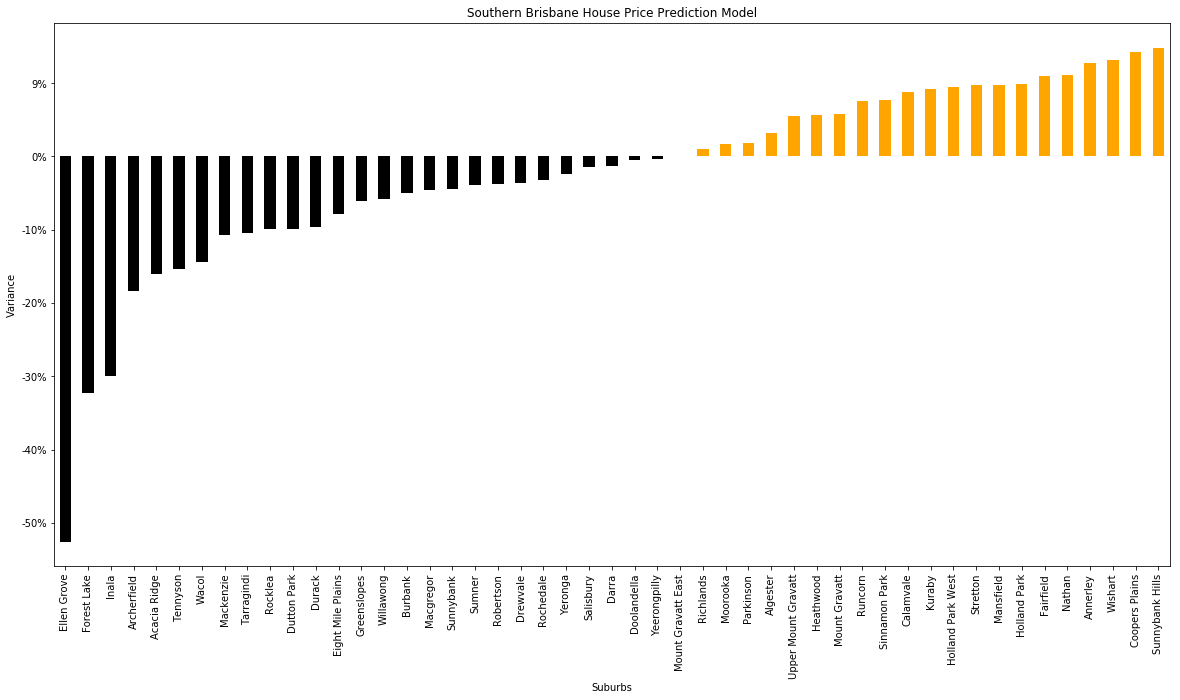

In [112]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    p=(100 * y).astype(int)
    s = str(p)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
formatter = FuncFormatter(to_percent)

plt.gca().yaxis.set_major_formatter(formatter)

predict_finalhis=predict_final.set_index('Suburbs')

predict_finalhis['Variance'].plot(kind='bar', figsize=(20, 10),  color=(predict_finalhis['Variance'] > 0).map({True: 'orange',
                                                    False: 'black'}))

plt.title('Southern Brisbane House Price Prediction Model')
plt.ylabel('Variance')
plt.xlabel('Suburbs')

plt.show()

#####  Observations and Conclusion:  #####
We have used the Unsupervised Machine Learning Algorithms:K-means clustering and Supervised Machine Learning Algorithms:Multiple linear regression to predict whether a suburb in Southern Brisbane is undervalued. From the analysis, seems that the west side of the Southern Brisbane Suburbs have been undervalued most.Especially Ellen Grove, which has a median market price of AUD 288K and predicted price of AUD 440K.   <br>

This analysis might have some limitations as there are many other factors other than venues, population, income that have impacts on House Prices. A more sofisticated model can be built incorporating data such as crime rates, employeement rates, school rankings,etc...<br>

However, my friend JV is happy enough with the initial analysis and planned his weekend house inspections around Ellen Grove and Forest Lake, let's wish him good luck.

Thank you for reviewing my work.